**Секція 1. Логістична регресія з нуля.**

Будемо крок за кроком будувати модель лог регресії з нуля для передбачення, чи буде врожай більше за 80 яблук (задача подібна до лекційної, але на класифікацію).

Давайте нагадаємо основні формули для логістичної регресії.

### Функція гіпотези - обчислення передбачення у логістичній регресії:

$$
\hat{y} = \sigma(x W^T + b) = \frac{1}{1 + e^{-(x W^T + b)}}
$$

Де:
- $ \hat{y} $ — це ймовірність "позитивного" класу.
- $ x $ — це вектор (або матриця для набору прикладів) вхідних даних.
- $ W $ — це вектор (або матриця) вагових коефіцієнтів моделі.
- $ b $ — це зміщення (bias).
- $ \sigma(z) $ — це сигмоїдна функція активації.

### Як обчислюється сигмоїдна функція:

Сигмоїдна функція $ \sigma(z) $ має вигляд:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Ця функція перетворює будь-яке дійсне значення $ z $ в інтервал від 0 до 1, що дозволяє інтерпретувати вихід як ймовірність для логістичної регресії.

### Формула функції втрат для логістичної регресії (бінарна крос-ентропія):

Функція втрат крос-ентропії оцінює, наскільки добре модель передбачає класи, порівнюючи передбачені ймовірності $ \hat{y} $ із справжніми мітками $ y $. Формула наступна:

$$
L(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$

Де:
- $ y $ — це справжнє значення (мітка класу, 0 або 1).
- $ \hat{y} $ — це передбачене значення (ймовірність).



1.
Тут вже наведений код для ініціювання набору даних в форматі numpy. Перетворіть `inputs`, `targets` на `torch` тензори. Виведіть результат на екран.

In [1936]:
import torch
import numpy as np

In [1937]:
# Вхідні дані (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Таргети (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)

tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])


2. Ініціюйте ваги `w`, `b` для моделі логістичної регресії потрібної форми зважаючи на розмірності даних випадковими значеннями з нормального розподілу. Лишаю тут код для фіксації `random_seed`.

In [1938]:
inputs.shape, targets.shape

(torch.Size([5, 3]), torch.Size([5, 1]))

In [1939]:
inputs.shape

torch.Size([5, 3])

In [1940]:
# x * W + b -> [5, 3] * [3, 1] + [1] -> [5, 1]
torch.random.manual_seed(1)
w = torch.randn(3, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
print(f'W: {w}')
print(f'b: {b}')


W: tensor([[0.6614],
        [0.2669],
        [0.0617]], requires_grad=True)
b: tensor([0.6213], requires_grad=True)


3. Напишіть функцію `model`, яка буде обчислювати функцію гіпотези в логістичній регресії і дозволяти робити передбачення на основі введеного рядка даних і коефіцієнтів в змінних `w`, `b`.

  **Важливий момент**, що функція `model` робить обчислення на `torch.tensors`, тож для математичних обчислень використовуємо фукнціонал `torch`, наприклад:
  - обчсилення $e^x$: `torch.exp(x)`
  - обчсилення $log(x)$: `torch.log(x)`
  - обчислення середнього значення вектору `x`: `torch.mean(x)`

  Використайте функцію `model` для обчислення передбачень з поточними значеннями `w`, `b`.Виведіть результат обчислень на екран.

  Проаналізуйте передбачення. Чи не викликають вони у вас підозр? І якщо викликають, то чим це може бути зумовлено?

In [1941]:
def model(x, w, b):
    sigmoid = 1 / (1 + torch.exp(-(x @ w + b)))
    return sigmoid

In [1942]:
preds = model(inputs, w, b) 
preds

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<MulBackward0>)

In [1943]:
preds, targets

(tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], grad_fn=<MulBackward0>),
 tensor([[0.],
         [1.],
         [1.],
         [0.],
         [1.]]))

чому не ймовірності? - нкеоптиальна кривизка сигмоїди

4. Напишіть функцію `binary_cross_entropy`, яка приймає на вхід передбачення моделі `predicted_probs` та справжні мітки в даних `true_labels` і обчислює значення втрат (loss)  за формулою бінарної крос-ентропії для кожного екземпляра та вертає середні втрати по всьому набору даних.
  Використайте функцію `binary_cross_entropy` для обчислення втрат для поточних передбачень моделі.

In [1944]:
def binary_cross_entropy(y_pred, y_true):
    y_pred = y_pred.clamp(min=1e-7, max=1-1e-7) # avoid log(0)
    L = y_true*torch.log(y_pred) + (1 - y_true)*torch.log(1 - y_pred)
    return (-L).mean()

In [1945]:
loss = binary_cross_entropy(preds, targets)
loss

tensor(6.3770, grad_fn=<MeanBackward0>)

5. Зробіть зворотнє поширення помилки і виведіть градієнти за параметрами `w`, `b`. Проаналізуйте їх значення. Як гадаєте, чому вони саме такі?

In [1946]:
loss.backward()
w.grad, b.grad

(tensor([[0.],
         [0.],
         [0.]]),
 tensor([0.]))

**Що сталось?**

В цій задачі, коли ми ініціювали значення випадковими значеннями з нормального розподілу, насправді ці значення не були дуже гарними стартовими значеннями і привели до того, що градієнти стали дуже малими або навіть рівними нулю (це призводить до того, що градієнти "зникають"), і відповідно при оновленні ваг у нас не буде нічого змінюватись. Це називається `gradient vanishing`. Це відбувається через **насичення сигмоїдної функції активації.**

У нашій задачі ми використовуємо сигмоїдну функцію активації, яка має такий вигляд:

   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}
   $$


Коли значення $z$ дуже велике або дуже мале, сигмоїдна функція починає "насичуватись". Це означає, що для великих позитивних $z$ сигмоїда наближається до 1, а для великих негативних — до 0. В цих діапазонах градієнти починають стрімко зменшуватись і наближаються до нуля (бо градієнт - це похідна, похідна на проміжку функції, де вона паралельна осі ОХ, дорівнює 0), що робить оновлення ваг неможливим.

![](https://editor.analyticsvidhya.com/uploads/27889vaegp.png)

У логістичній регресії $ z = x \cdot w + b $. Якщо ваги $w, b$ - великі, значення $z$ також буде великим, і сигмоїда перейде в насичену область, де градієнти дуже малі.

Саме це сталося в нашій задачі, де великі випадкові значення ваг викликали насичення сигмоїдної функції. Це в свою чергу призводить до того, що під час зворотного поширення помилки (backpropagation) модель оновлює ваги дуже повільно або зовсім не оновлює. Це називається проблемою **зникнення градієнтів** (gradient vanishing problem).

**Що ж робити?**
Ініціювати ваги маленькими значеннями навколо нуля. Наприклад ми можемо просто в існуючій ініціалізації ваги розділити на 1000. Можна також використати інший спосіб ініціалізації вагів - інформація про це [тут](https://www.geeksforgeeks.org/initialize-weights-in-pytorch/).

Як це робити - показую нижче. **Виконайте код та знову обчисліть передбачення, лосс і виведіть градієнти.**

А я пишу пояснення, чому просто не зробити

```
w = torch.randn(1, 3, requires_grad=True)/1000
b = torch.randn(1, requires_grad=True)/1000
```

Нам потрібно, аби тензори вагів були листовими (leaf tensors).

1. **Що таке листовий тензор**
Листовий тензор — це тензор, який був створений користувачем безпосередньо і з якого починається обчислювальний граф. Якщо такий тензор має `requires_grad=True`, PyTorch буде відслідковувати всі операції, виконані над ним, щоб правильно обчислювати градієнти під час навчання.

2. **Чому ми використовуємо `w.data` замість звичайних операцій**
Якщо ми просто виконали б операції, такі як `(w - 0.5) / 100`, ми б отримали **новий тензор**, який вже не був би листовим тензором, оскільки ці операції створюють **новий** тензор, а не модифікують існуючий.

  Проте, щоб залишити наші тензори ваги `w` та зміщення `b` листовими і продовжити можливість відстеження градієнтів під час тренування, ми використовуємо атрибут `.data`. Цей атрибут дозволяє **виконувати операції in-place (прямо на існуючому тензорі)** без зміни самого об'єкта тензора. Отже, тензор залишається листовим, і PyTorch може коректно обчислювати його градієнти.

3. **Чому важливо залишити тензор листовим**
Якщо тензор більше не є листовим (наприклад, через проведення операцій, що створюють нові тензори), ви не зможете отримати градієнти за допомогою `w.grad` чи `b.grad` після виклику `loss.backward()`. Це може призвести до втрати можливості оновлення параметрів під час тренування моделі. В нашому випадку ми хочемо, щоб тензори `w` та `b` накопичували градієнти, тому вони повинні залишатись листовими.

**Висновок:**
Ми використовуємо `.data`, щоб виконати операції зміни значень на ваги і зміщення **in-place**, залишаючи їх листовими тензорами, які можуть накопичувати градієнти під час навчання. Це дозволяє коректно працювати механізму зворотного поширення помилки (backpropagation) і оновлювати ваги моделі.

5. Виконайте код та знову обчисліть передбачення, лосс і знайдіть градієнти та виведіть всі ці тензори на екран.

In [1947]:
torch.random.manual_seed(1)
w = torch.randn(3, 1, requires_grad=True)  # Листовий тензор w = torch.randn(1, 3, requires_grad=True) 
b = torch.randn(1, requires_grad=True)     # Листовий тензор

# in-place операції
w.data = w.data / 1000
b.data = b.data / 1000

In [1948]:
w, b

(tensor([[6.6135e-04],
         [2.6692e-04],
         [6.1677e-05]], requires_grad=True),
 tensor([0.0006], requires_grad=True))

In [1949]:
preds_2 = model(inputs, w, b)
print(preds_2)

loss_2 = binary_cross_entropy(preds_2, targets)
print(loss_2)

tensor([[0.5174],
        [0.5220],
        [0.5244],
        [0.5204],
        [0.5190]], grad_fn=<MulBackward0>)
tensor(0.6829, grad_fn=<MeanBackward0>)


In [1950]:
loss_2.backward() 
w.grad, b.grad

(tensor([[ -5.4417],
         [-18.9853],
         [-10.0682]]),
 tensor([-0.0794]))

6. Напишіть алгоритм градієнтного спуску, який буде навчати модель з використанням написаних раніше функцій і виконуючи оновлення ваг. Алгоритм має включати наступні кроки:

    1. Генерація прогнозів
    2. Обчислення втрат
    3. Обчислення градієнтів (gradients) loss-фукнції відносно ваг і зсувів
    4. Налаштування ваг шляхом віднімання невеликої величини, пропорційної градієнту (`learning_rate` домножений на градієнт)
    5. Скидання градієнтів на нуль

Виконайте градієнтний спуск протягом 1000 епох, обчисліть фінальні передбачення і проаналізуйте, чи вони точні?

In [1951]:
def gradient(w, b, X, y, learning_rate = 0.001, epoch = 1000):
    for i in range (epoch):
        preds = model(X, w, b)
        loss = binary_cross_entropy(preds, y)
        loss.backward()
        with torch.no_grad():
            w -= w.grad * learning_rate
            b -= b.grad * learning_rate

            w.grad.zero_()
            b.grad.zero_()

        if (i % 100 == 0):   
            print(f'epoch {i}: loss = {loss}')  

    print(f'epoch {i}: loss = {loss}') # last epoch loss
    return w, b  

In [1952]:
w_final, b_final = gradient(w, b, inputs, targets, learning_rate = 0.001, epoch = 1000)

epoch 0: loss = 0.6829456686973572
epoch 100: loss = 0.1976310759782791


epoch 200: loss = 0.16219036281108856
epoch 300: loss = 0.13796377182006836
epoch 400: loss = 0.11963770538568497
epoch 500: loss = 0.10523231327533722
epoch 600: loss = 0.09364274144172668
epoch 700: loss = 0.08415224403142929
epoch 800: loss = 0.07626529037952423
epoch 900: loss = 0.06962653994560242
epoch 999: loss = 0.06402736902236938


In [1953]:
preds_final = model(inputs, w_final, b_final)
print(f'Output: \n{preds_final}\n')
preds_round = preds_final.round()
print(f'Rounded output: \n{preds_round}\n')
print(f'Target: \n{targets}\n')

accuracy = (preds_round == targets).float().mean()  
print(f'accuracy = {accuracy}')

Output: 
tensor([[1.6794e-01],
        [8.7485e-01],
        [9.9769e-01],
        [2.3414e-07],
        [9.9999e-01]], grad_fn=<MulBackward0>)

Rounded output: 
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)

Target: 
tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])

accuracy = 1.0


**Секція 2. Створення лог регресії з використанням функціоналу `torch.nn`.**

Давайте повторно реалізуємо ту ж модель, використовуючи деякі вбудовані функції та класи з PyTorch.

Даних у нас буде побільше - тож, визначаємо нові масиви.

In [1954]:
# Вхідні дані (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Таргети (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

7. Завантажте вхідні дані та мітки в PyTorch тензори та з них створіть датасет, який поєднує вхідні дані з мітками, використовуючи клас `TensorDataset`. Виведіть перші 3 елементи в датасеті.



In [1955]:
import torch.nn as nn   
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs.shape, targets.shape)

train_ds = TensorDataset(inputs, targets)
train_ds[0:3]

torch.Size([15, 3]) torch.Size([15, 1])


(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[0.],
         [1.],
         [1.]]))

8. Визначте data loader з класом **DataLoader** для підготовленого датасету `train_ds`, встановіть розмір батчу на 5 та увімкніть перемішування даних для ефективного навчання моделі. Виведіть перший елемент в дата лоадері.

In [1956]:
batch_size = 5
torch.random.manual_seed(1)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

[tensor([[ 69.,  96.,  70.],
         [ 91.,  88.,  64.],
         [ 69.,  96.,  70.],
         [ 87., 134.,  58.],
         [ 73.,  67.,  43.]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [0.]])]

9. Створіть клас `LogReg` для логістичної регресії, наслідуючи модуль `torch.nn.Module` за прикладом в лекції (в частині про FeedForward мережі).

  У нас модель складається з лінійної комбінації вхідних значень і застосування фукнції сигмоїда. Тож, нейромережа буде складатись з лінійного шару `nn.Linear` і використання активації `nn.Sigmid`. У створеному класі мають бути реалізовані методи `__init__` з ініціалізацією шарів і метод `forward` для виконання прямого проходу моделі через лінійний шар і функцію активації.

  Створіть екземпляр класу `LogReg` в змінній `model`.

In [1957]:
class LogReg (nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.act(x)
        return x    

In [1958]:
model = LogReg()
print(model)

LogReg(
  (linear): Linear(in_features=3, out_features=1, bias=True)
  (act): Sigmoid()
)


10. Задайте оптимізатор `Stockastic Gradient Descent` в змінній `opt` для навчання моделі логістичної регресії. А також визначіть в змінній `loss` функцію втрат `binary_cross_entropy` з модуля `torch.nn.functional` для обчислення втрат моделі. Обчисліть втрати для поточних передбачень і міток, а потім виведіть їх. Зробіть висновок, чи моделі вдалось навчитись?

In [1959]:
opt = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.functional.binary_cross_entropy

loss_init = loss_fn(model(inputs), targets) # first initialization of the model
loss_init

tensor(9.2144, grad_fn=<BinaryCrossEntropyBackward0>)

11. Візьміть з лекції функцію для тренування моделі з відстеженням значень втрат і навчіть щойно визначену модель на 1000 епохах. Виведіть після цього графік зміни loss, фінальні передбачення і значення таргетів.

In [1960]:
def fit_return_loss(num_epochs, model, loss_fn, opt, train_dl):
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0

        for xb, yb in train_dl:

            pred = model(xb)
            loss = loss_fn(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

            total_loss += loss.item()

        if (epoch % 100 == 0):   
            print(f'epoch {epoch}: loss = {loss}')     

        avg_loss = total_loss / len(train_dl)
        losses.append(avg_loss)

    print(f'epoch {i}: loss = {loss}') # last epoch loss
          
    return losses

In [1961]:
loss_all = fit_return_loss(1000, model, loss_fn, opt, train_dl)

epoch 0: loss = 1.9916292428970337
epoch 100: loss = 0.11025043576955795
epoch 200: loss = 0.08742951601743698
epoch 300: loss = 0.08423562347888947
epoch 400: loss = 0.056801341474056244
epoch 500: loss = 0.021527431905269623
epoch 600: loss = 0.06468220055103302
epoch 700: loss = 0.015324476175010204
epoch 800: loss = 0.038393765687942505
epoch 900: loss = 6.565875979495828e-18
epoch 999: loss = 0.03812045976519585


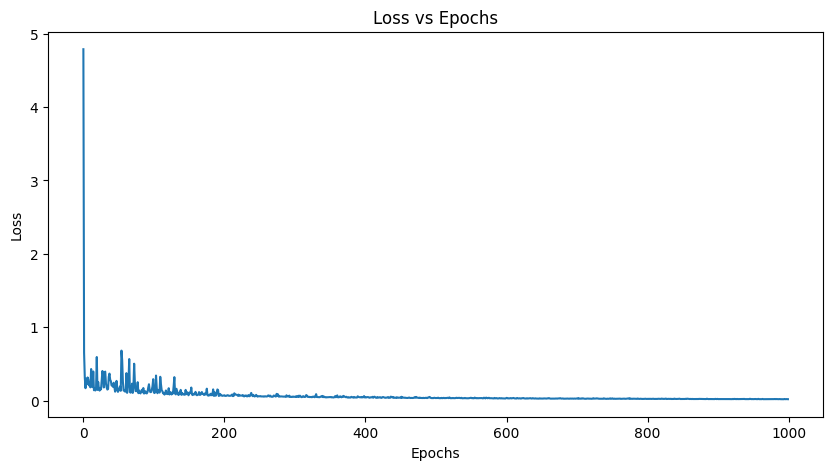

In [1962]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss_all)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
preds = model(inputs)
accuracy = (preds > 0.5).int() == targets.int()
accuracy = accuracy.float().sum() / len(accuracy)
print(f'accuracy = {accuracy}')
(preds > 0.5).int(), targets  

accuracy = 1.0


(tensor([[0],
         [1],
         [1],
         [0],
         [1],
         [0],
         [1],
         [1],
         [0],
         [1],
         [0],
         [1],
         [1],
         [0],
         [1]], dtype=torch.int32),
 tensor([[0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [0.],
         [1.]]))